In [1]:
#Importation des bibliotheques
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot
import transformers
from transformers import BertTokenizer, BertModel, BertConfig
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from model import Model
from tweet_dataset import TweetDataset
from neural_network import NeuralNetwork

Using cache found in C:\Users\Abdou/.cache\torch\hub\huggingface_pytorch-transformers_main


In [2]:
#Definition de constante
SEED = 42 
BATCH_SIZE = 64 
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
EPOCHS = 2
EPOCHS_BLUSKY = 1
NBDATA = 500
LR = 3e-5
FREEZE = False

In [3]:
#Chargement de notre dataset d'entrainement
raw_dataset = load_dataset("EleutherAI/twitter-sentiment")

#On a pas besoin de la colonne unnamed
dataset = raw_dataset.remove_columns("source")
dataset = dataset.remove_columns("id")

#Les donnees étaient rangés dans l'ordre des sentiments 
dataset = dataset.shuffle(seed=48)

#On va prendre NBDATA tweets pour entrainer et tester notre model
dataset = dataset["train"].select(range(NBDATA))

#creation des dataset de train-validation-test
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed = 48)
train_data = dataset['train']
generalisation_test = dataset['test'].train_test_split(test_size=0.5,shuffle=True, seed = 48)
validation_data = generalisation_test["train"]
test_data = generalisation_test["test"]
from collections import Counter

def count_classes(dataset, label_column="label"):
    labels = [example[label_column] for example in dataset]
    return Counter(labels)

print("Train:", count_classes(train_data))
print("Validation:", count_classes(validation_data))
print("Test:", count_classes(test_data))


Train: Counter({1: 214, 0: 186})
Validation: Counter({0: 25, 1: 25})
Test: Counter({1: 26, 0: 24})


In [4]:
train_data = TweetDataset(train_data)
validation_data = TweetDataset(validation_data)
test_data = TweetDataset(test_data)

In [5]:
model = NeuralNetwork(n_labels=1, freeze_params=FREEZE).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [6]:
sbs = Model(model, loss_fn, optimizer)
sbs.set_seed()
twitter_train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers = 0)
twitter_validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers = 0)
twitter_test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers = 0)
sbs.set_loader(twitter_train_dataloader, twitter_validation_dataloader)

In [ ]:
start_train = time.time()
sbs.train(n_epochs=EPOCHS)
sbs.metrics()
end_train = time.time()
print(f'Execution time : {end_train - start_train}')

In [ ]:
sbs.plot_losses("C:\\Users\\Abdou\\Documents\\POLYTECH\\4A\\PROJET_4A\\IMAGE\\{NBDATA}_{EPOCHS}_{FREEZE}_{LR}.png")

In [9]:
sbs.predict(twitter_test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


{'f1_score': 0.75, 'accuracy': 0.68, 'roc_auc': np.float64(0.832)}


In [ ]:
#sbs.save_checkpoint('./Model/model_T2_B1_500_nofreeze')

In [7]:
sbs.load_checkpoint('./Model/model_T2_B1_500_nofreeze')


C:\Users\Abdou\Documents\GitHub\Catastrophic_forgetting\model.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=self.to(se

✅ Modèle chargé depuis ./Model/model_T2_B1_500_nofreeze, entraîné pendant 2 époques.


## Test sur d'autre jeux de données 

In [ ]:
ds = load_dataset("PrkhrAwsti/Twitter_Sentiment_3M")
#On a pas besoin de la colonne unnamed
ds = ds.remove_columns("Unnamed: 0")

ds = ds.shuffle(seed=48)
ds = ds["train"].select(range(10000))

ds = ds.map(lambda example: {'label': example['sentiment'], 'text': example['tweet']}, remove_columns=['sentiment','tweet'])

In [ ]:
test_data = TweetDataset(ds)
test_dataloader = DataLoader(test_data, batch_size=64)
sbs.predict(test_dataloader)

In [8]:
class OtherDataset(Dataset):
    def __init__(self, encodings,
                 tokenizer=torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased'),
                 max_length=180):
        self.encodings = encodings
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __getitem__(self, index):
        text = self.encodings.iloc[index] if hasattr(self.encodings, 'iloc') else self.encodings[index]
        inputs = self.tokenizer(
            text=text['text'],
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )
        target = text['label']
        # Use string comparison for labels
        target = 0 if target == 'Negative' else 1# if target == 'Positive' else [0, 0,1 ]
        
        return {
            'ids': inputs['input_ids'].squeeze(0).to(self.device),
            'token_type_ids': inputs['token_type_ids'].squeeze(0).to(self.device),
            'attention_mask': inputs['attention_mask'].squeeze(0).to(self.device),
            'target': torch.tensor(target, dtype=torch.float).to(self.device)
        }

    def __len__(self):
        return len(self.encodings)

Using cache found in C:\Users\Abdou/.cache\torch\hub\huggingface_pytorch-transformers_main


In [9]:
df_bluesky = pd.read_csv('bluesky.csv')
df_bluesky = df_bluesky.drop(['Unnamed: 0','score'],axis=1)
df_bluesky = df_bluesky[df_bluesky['label'].isin(['Positive', 'Negative'])]
test_data = OtherDataset(df_bluesky)
test_dataloader = DataLoader(test_data, batch_size=64)
sbs.predict(test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:50<00:00,  2.90it/s]

{'f1_score': 0.549, 'accuracy': 0.485, 'roc_auc': np.float64(0.512)}


In [ ]:
from datasets import load_dataset
ds = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
test = TweetDataset(ds["train"].filter(lambda exemple: exemple['label'] in [0, 2]))
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE)
sbs.predict(test_dataloader)

## Transfert Learning sur Bleusky

In [10]:
from sklearn.model_selection import train_test_split
df_bluesky = df_bluesky.sample(n=1000, random_state=SEED)

# Split train/test/validation
train_df, temp_df = train_test_split(df_bluesky, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

# Création des datasets
train_dataset = OtherDataset(train_df)
val_dataset = OtherDataset(val_df)
test_dataset = OtherDataset(test_df)

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
sbs.set_loader(train_loader, val_loader)
start_train = time.time()
sbs.train(n_epochs=EPOCHS_BLUSKY )
sbs.metrics()
end_train = time.time()
print(f'Execution time : {end_train - start_train}')

Execution time : 27.20826768875122


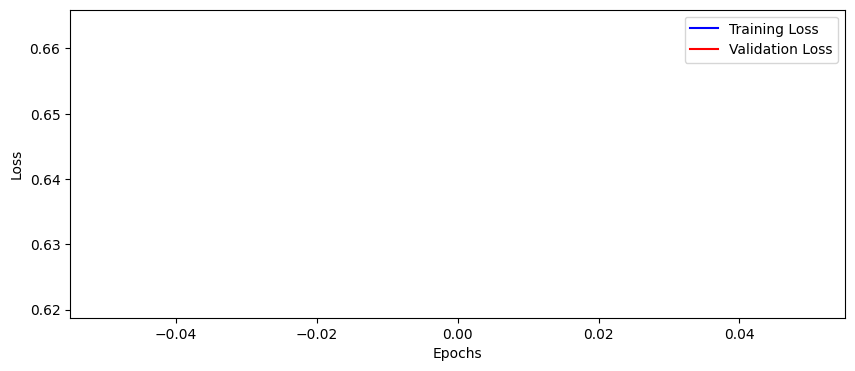

In [12]:
sbs.plot_losses()

In [13]:
sbs.predict(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.74it/s]

{'f1_score': 0.633, 'accuracy': 0.71, 'roc_auc': np.float64(0.772)}


In [14]:
sbs.predict(twitter_test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]

{'f1_score': 0.741, 'accuracy': 0.72, 'roc_auc': np.float64(0.825)}
